In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [76]:
def tdma(N, a, b, c, d, T):
    P = np.zeros(N)
    Q = np.zeros(N)

    # west BC, T[0] is known so P[0] = 0 and Q[0] is T[0]
    P[0] = 0
    Q[0] = 100

    # setting up the inside elements
    for i in range(1, N-1): 
        P[i] = b[i] / (a[i] - c[i] * P[i-1])
        Q[i] = (d[i] + c[i] * Q[i-1]) / (a[i] - c[i] *P[i-1])

    # east BC, T[N] is known
    P[N-1] = 0
    Q[N-1] = 20

    for i in range(N-2, -1, -1): # backwards solve
        T[i] = P[i] * T[i+1] + Q[i]
    
    return T.copy()

def analytical(grid, L, Pe):
    return 100 + ((np.exp(grid * Pe / L) - 1) / (np.exp(Pe) - 1) * (20-100))

def error_calc(grid, analytical_value, numerical_value):
    E = 100 * round((sum(abs((numerical_value - analytical_value)/analytical_value)) / grid),4)
    return f'{E} %' 

def plotting(grid, scheme_results, analytical_results, title, error_value, Pe_G, Pe_L):
    fig, ax = plt.subplots()
    ax.plot(grid, analytical_results, label=f'Analytical', c='black')
    ax.plot(grid, scheme_results, label=f'Numerical, Error:{error_value}', 
            c='blue', ls='--', marker='o', mfc='red')
    # ax.scatter(grid, scheme_results, c='red')

    ax.set_title(f"{title} \n Pe Global: {Pe_G}, Pe Local: {Pe_L}")
    ax.set_xlabel('x / L')
    ax.set_ylabel('Temperature')
    ax.legend()

    return plt.show()

In [9]:
# a is current, b is upstream, c is downstream, d is source
def cds(N, gamma, dx, rho, u, temp):
    a = np.zeros(N)
    b = np.zeros(N)
    c = np.zeros(N)
    d = np.zeros(N)
    for i in range(1,N-1):
        b[i] = gamma / dx - 0.5 * rho * u
        c[i] = gamma / dx + 0.5 * rho * u
        a[i] = b[i] + c[i] + d[i]

    return tdma(N, a, b, c, d, temp)

def uds(N, gamma, dx, rho, u, temp):
    a = np.zeros(N)
    b = np.zeros(N)
    c = np.zeros(N)
    d = np.zeros(N)
    for i in range(1, N-1):
        b[i] = gamma / dx + max(-(rho * u), 0)
        c[i] = gamma / dx + max((rho * u), 0)
        a[i] = b[i] + c[i] + d[i]

    return tdma(N, a, b, c, d, temp)

def pds(N, gamma, dx, rho, u, temp, Pe):
    a = np.zeros(N)
    b = np.zeros(N)
    c = np.zeros(N)
    d = np.zeros(N)
    for i in range(1, N-1):
        b[i] = (gamma / dx) * max((1 - 0.1 * abs(Pe))**5,0) + max(-(rho * u), 0)
        c[i] = (gamma / dx) * max((1 - 0.1 * abs(Pe))**5,0) + max((rho * u), 0)
        a[i] = b[i] + c[i] + d[i]
        
    return tdma(N, a, b, c, d, temp)

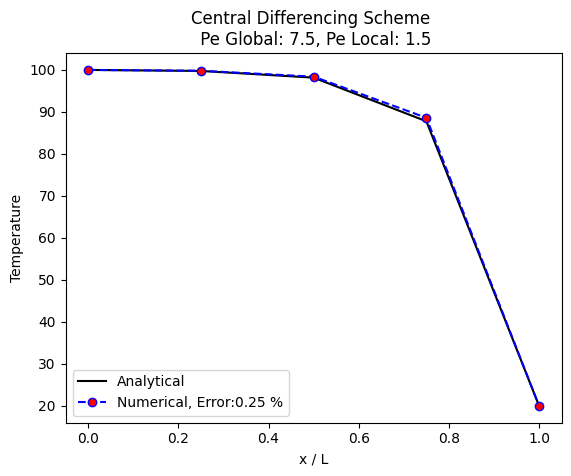

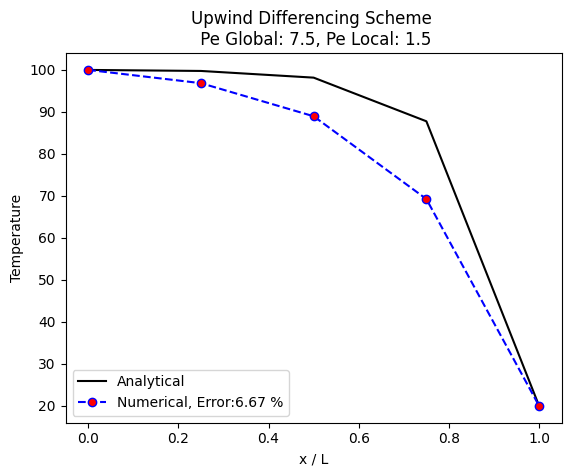

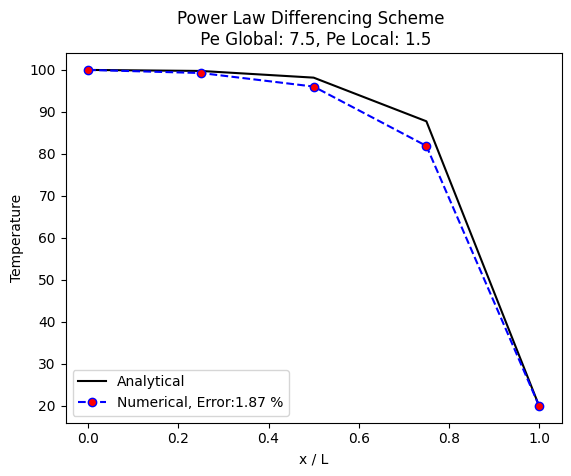

[None, None, None]

In [ ]:
def solve():
    # Domain setup
    length = 1.0 # m
    cell_count = 5
    delta_x = length / cell_count
    x_grid = np.linspace(0, length, cell_count)

    # Fluid and Flow Properties setup
    gamma_T = 0.1 # diffusivity, between 0.1 and 1.0
    density = 1.0 # kg/m^3, value between 0.1 and 1.0
    Temp = np.full(cell_count,20.0) # deg C, T field initialisation
    vel = 0.75 #m/s

    # Equations Setup
    Pe_global = round((density * vel * length / gamma_T),3)
    Pe_local = round((density * vel * delta_x / gamma_T),3)
    
    T_cds = cds(cell_count, gamma_T, delta_x, density, vel, Temp)
    T_uds = uds(cell_count, gamma_T, delta_x, density, vel, Temp)
    T_pds = pds(cell_count, gamma_T, delta_x, density, vel, Temp, Pe_local)
    T_analytical = analytical(x_grid, length, Pe_global)

    # Errors
    Error_cds = error_calc(cell_count, T_analytical, T_cds)
    Error_uds = error_calc(cell_count, T_analytical, T_uds)
    Error_pds = error_calc(cell_count, T_analytical, T_pds)

    result_lists = [T_cds, T_uds, T_pds]
    result_names = ["Central Differencing Scheme",
                    "Upwind Differencing Scheme",
                    "Power Law Differencing Scheme",]
    error_vals = [Error_cds, Error_uds, Error_pds]

    figures = []

    for i, j, k in zip(result_lists, result_names, error_vals):
        figure = plotting(x_grid, i, T_analytical, j, k, Pe_global, Pe_local)
        figures.append(figure)
        
    return figures

solve()